<a href="https://colab.research.google.com/github/kushv16/Audio-Sentiment-Analysis/blob/master/CNN_on_2D_MFCC_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [38]:
# import libraries
import pandas as pd
import numpy as np
import librosa
import librosa.display
import random
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
%matplotlib inline
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  

In [32]:
df = pd.read_csv('/content/drive/MyDrive/LY Project/combo.csv')


df.head()

,path,filename,dataset,duration,sample_rate,gender,age,emotion,f0_mean,f0_median,...,mfcc21_var,mfcc22_var,mfcc23_var,mfcc24_var,mfcc25_var,mfcc26_var,mfcc27_var,mfcc28_var,mfcc29_var,mfcc30_var
0,ravdess-emotional-speech-audio/Actor_01/03-01-...,03-01-01-01-01-01-01,RAVDESS,3.303,48000,male,26,neutral,112.335199,109.684328,...,29.315643,36.579422,28.419561,20.604578,34.236244,17.831990,47.886536,34.304970,32.610954,25.258045
1,ravdess-emotional-speech-audio/Actor_01/03-01-...,03-01-01-01-01-02-01,RAVDESS,3.337,48000,male,26,neutral,117.048401,114.869835,...,39.815510,44.388800,35.062126,16.261528,26.367765,17.877956,39.467236,34.620537,38.908985,23.834513
2,ravdess-emotional-speech-audio/Actor_01/03-01-...,03-01-01-01-02-01-01,RAVDESS,3.270,48000,male,26,neutral,113.449176,109.050773,...,22.035300,37.271484,41.312490,37.438225,32.081330,30.129055,40.721256,23.911890,8.379778,28.543652
3,ravdess-emotional-speech-audio/Actor_01/03-01-...,03-01-01-01-02-02-01,RAVDESS,3.170,48000,male,26,neutral,112.750895,112.896440,...,31.971504,36.978264,18.796390,35.866673,42.234043,26.264517,42.082623,24.384457,41.745533,36.165436
4,ravdess-emotional-speech-audio/Actor_01/03-01-...,03-01-03-01-01-01-01,RAVDESS,3.470,48000,male,26,happy,149.054000,144.729338,...,61.203896,63.172386,35.944280,25.528050,28.051268,22.667345,10.932018,16.455738,23.799614,19.917862


In [29]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
from tqdm import tqdm

for idx in tqdm(df.index):
  file = df['filename'][idx]
  if(df['dataset'][idx] == 'RAVDESS'):
      path = "/content/drive/MyDrive/LY Project/Cleaned Datasets/cleaned_samples_tess_savee_ravdess_crema/" + file + "_cleaned.wav"
  elif(df['dataset'][idx] == 'CREMA'):   
      path = "/content/drive/MyDrive/LY Project/Cleaned Datasets/cleaned_samples_tess_savee_ravdess_crema/" + file + "_cleaned.wav"
  elif(df['dataset'][idx] == 'EmoV_DB'):
      path = "/content/drive/MyDrive/LY Project/Cleaned Datasets/cleaned_samples_emodb/" + file.split('.')[0] + "_cleaned.wav"
  elif(df['dataset'][idx] == 'JL-Corpus'):
      path = "/content/drive/MyDrive/LY Project/Cleaned Datasets/cleaned_samples_jlcorpus/" + file
  elif(df['dataset'][idx] == 'SAVEE'):
    path = "/content/drive/MyDrive/LY Project/Cleaned Datasets/cleaned_samples_savee/" + file + "_cleaned.wav"
  elif(df['dataset'][idx] == 'TESS'):
    path = "/content/drive/MyDrive/LY Project/Cleaned Datasets/cleaned_samples_tess_savee_ravdess_crema/" + file + "_cleaned.wav"
  
  df['path'][idx] = path
  


100%|██████████| 16785/16785 [00:10<00:00, 1626.51it/s]


In [42]:
df['emotion'].unique()

array(['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust', 'surprise'],
      dtype=object)

In [43]:
%%time

# Create a variable where to store the mfccs data
mfccs = []

for file in tqdm(df.path):
  # load audio file:
  y, sr = librosa.load(file, sr=16000)

  # Extract 'n_mfcc' numbers of MFCCs components - in this case 30
  mfccs.append(librosa.feature.mfcc(y, sr=sr, fmin=50, n_mfcc=30))


100%|██████████| 16785/16785 [2:05:51<00:00,  2.22it/s]

CPU times: user 4min 57s, sys: 16min 58s, total: 21min 56s
Wall time: 2h 5min 51s


In [103]:
# Define function to resize the 2D arrays
def resize_array(array):
    new_matrix = np.zeros((30,200))   # Initialize the new matrix shape with an array 30X200 of zeros
    for i in range(30):               # Iterate rows
        for j in range(200):          # Iterate columns
            try:       
                new_matrix[i][j] = array[i][j]
            except IndexError:                   # if mfccs of a sample is shorter than 200, then keep looping to extend lenght to 200 with 0s
                pass
    return new_matrix

# Create a variable to store the new resized mfccs and apply function for all the extracted mfccs
resized_mfccs = []

for mfcc in tqdm(mfccs):
    resized_mfccs.append(resize_array(mfcc))

100%|██████████| 16785/16785 [01:44<00:00, 160.58it/s]


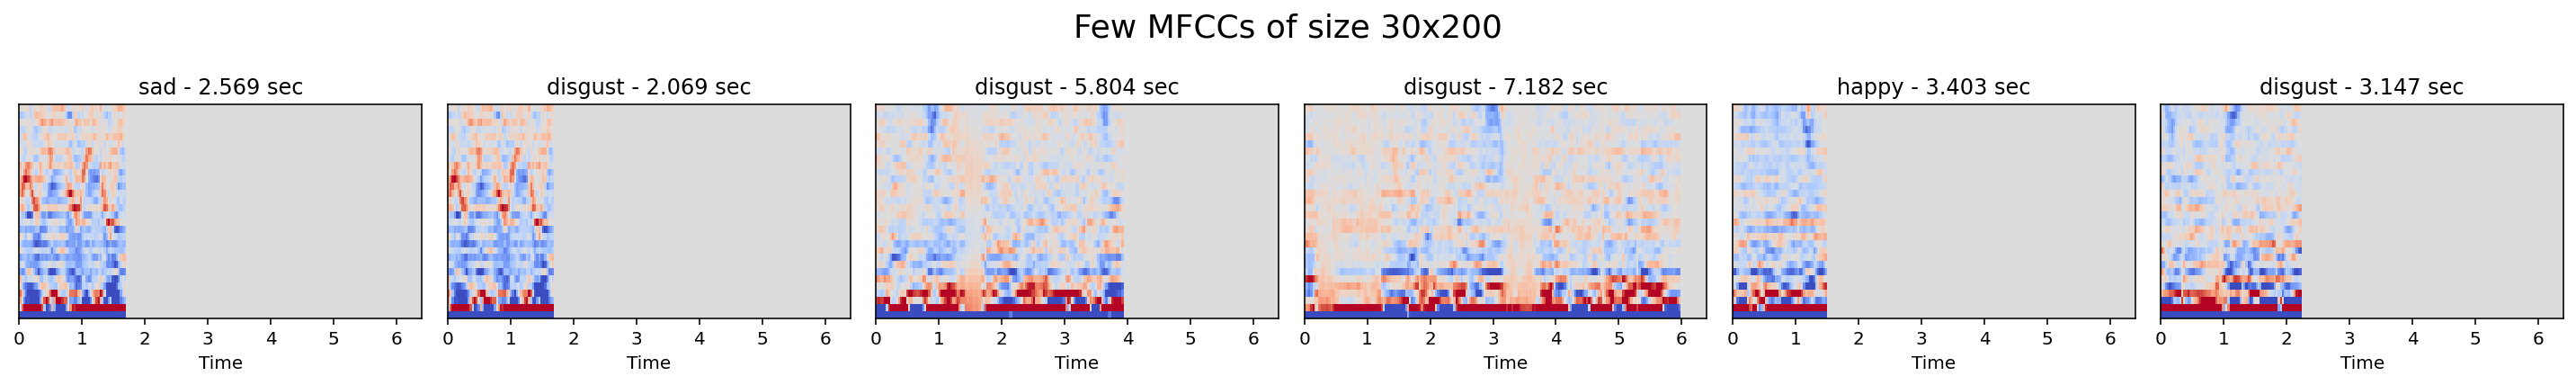

In [107]:
# Create sublots
fig, axs = plt.subplots(nrows=1,ncols=6, figsize=(20,3))

# Import normalize function to improve readibility
from matplotlib.colors import Normalize

# Select 6 random MFCCs
for i in range(6):
    index = random.randint(0, len(resized_mfccs))
    # Plot MFCCs
    librosa.display.specshow(resized_mfccs[index], sr=sr, x_axis="time", ax=axs[i], norm=Normalize(vmin=-50, vmax=50))
    axs[i].set_title(str(df['emotion'][index]) + ' - ' + str(df['duration'][index]) + ' sec')

plt.suptitle('Few MFCCs of size 30x200', size=18)
plt.tight_layout()
plt.show()

In [108]:
from sklearn.model_selection import train_test_split

# Select target
df['emotion'].replace({'angry':0,'disgust':1,'fear':2,'happy':3,'neutral':4,'sad':5,'surprise':6}, inplace=True)
y = df.emotion.values

# Features
X = resized_mfccs.copy()

# Create train, validation and test set
x_tr, x_te, y_tr, y_te = train_test_split(X, y, train_size=0.9, shuffle=True, stratify=y, random_state=0)
x_tr, x_va, y_tr, y_va = train_test_split(x_tr, y_tr, test_size=0.3, shuffle=True, stratify=y_tr, random_state=0)

# Convert data to numpy arrays
x_tr = np.array([i for i in x_tr])
x_va = np.array([i for i in x_va])
x_te = np.array([i for i in x_te])

# Plot size of dataset
print(x_tr.shape)
print(x_va.shape)
print(x_te.shape)

(10574, 30, 200)
(4532, 30, 200)
(1679, 30, 200)


In [109]:
cd '/content/drive/MyDrive/LY Project'

/content/drive/.shortcut-targets-by-id/1ty6Q2chm7khBo3iSNsdx5NVqeOpCUmjM/LY Project


In [110]:
np.save('x_tr.npy', x_tr)
np.save('x_va.npy', x_va)
np.save('x_te.npy', x_te)

In [111]:
np.save('y_tr.npy', y_tr)
np.save('y_va.npy', y_va)
np.save('y_te.npy', y_te)

In [112]:
# Get mean and standard deviation from the training set
tr_mean = np.mean(x_tr, axis=0)
tr_std = np.std(x_tr, axis=0)

# Apply data scaling
x_tr = (x_tr - tr_mean)/tr_std
x_va = (x_va - tr_mean)/tr_std
x_te = (x_te - tr_mean)/tr_std

In [113]:
# Add the 'channel' dimension to the MFCCs spectrum input 'images'
print(f"x_tr has a dimension of {x_tr.shape} before the manipulation.")

x_tr = x_tr[..., None]
x_va = x_va[..., None]
x_te = x_te[..., None]

print(f"x_tr has a dimension of {x_tr.shape} after the manipulation.")

x_tr has a dimension of (10574, 30, 200) before the manipulation.
x_tr has a dimension of (10574, 30, 200, 1) after the manipulation.


In [114]:
from tensorflow import keras
from tensorflow.keras.layers import (Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPool2D)
from tensorflow.keras import initializers

# Create convolutional neural network and return summary
model = keras.Sequential()
model.add(Conv2D(filters=256, kernel_size=5, strides=(2, 2), activation="relu", input_shape=x_tr.shape[1:]))
model.add(MaxPool2D(pool_size=2))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=4, strides=(2, 1), activation="relu"))
model.add(MaxPool2D(pool_size=2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=7, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 13, 98, 256)       6656      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 49, 256)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 6, 49, 256)       1024      
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 46, 128)        524416    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 23, 128)       0         
 2D)                                                             
                                                        

In [115]:
# Compile the model using Adam's default learning rate
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_tr), y= y_tr)
class_weights = dict(zip(np.unique(y_tr), class_weights))

# Create 'EarlyStopping' callback
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [116]:
%%time

#  Trains the neural network
history = model.fit(
    x=x_tr,
    y=y_tr,
    epochs=100,
    batch_size=32,
    validation_data=(x_va, y_va),
    callbacks=[earlystopping_cb],
    class_weight=class_weights,
)

Epoch 1/100
331/331 [==============================] - 18s 17ms/step - loss: 2.1415 - accuracy: 0.1757 - val_loss: 1.8144 - val_accuracy: 0.3131
Epoch 2/100
331/331 [==============================] - 8s 24ms/step - loss: 1.8096 - accuracy: 0.2505 - val_loss: 1.6845 - val_accuracy: 0.3756
Epoch 3/100
331/331 [==============================] - 4s 12ms/step - loss: 1.7181 - accuracy: 0.2830 - val_loss: 1.5546 - val_accuracy: 0.3879
Epoch 4/100
331/331 [==============================] - 4s 12ms/step - loss: 1.6328 - accuracy: 0.3101 - val_loss: 1.5456 - val_accuracy: 0.4095
Epoch 5/100
331/331 [==============================] - 4s 12ms/step - loss: 1.5854 - accuracy: 0.3326 - val_loss: 1.4750 - val_accuracy: 0.4371
Epoch 6/100
331/331 [==============================] - 4s 11ms/step - loss: 1.5276 - accuracy: 0.3557 - val_loss: 1.4367 - val_accuracy: 0.4477
Epoch 7/100
331/331 [==============================] - 4s 11ms/step - loss: 1.4663 - accuracy: 0.3723 - val_loss: 1.4119 - val_accuracy

In [117]:
hist_df = pd.DataFrame(history.history) 
hist_df.to_csv("/content/drive/MyDrive/LY Project/cnn_two_layers_history.csv")

model.save_weights("/content/drive/MyDrive/LY Project/cnn_two_layers_weights.h5")

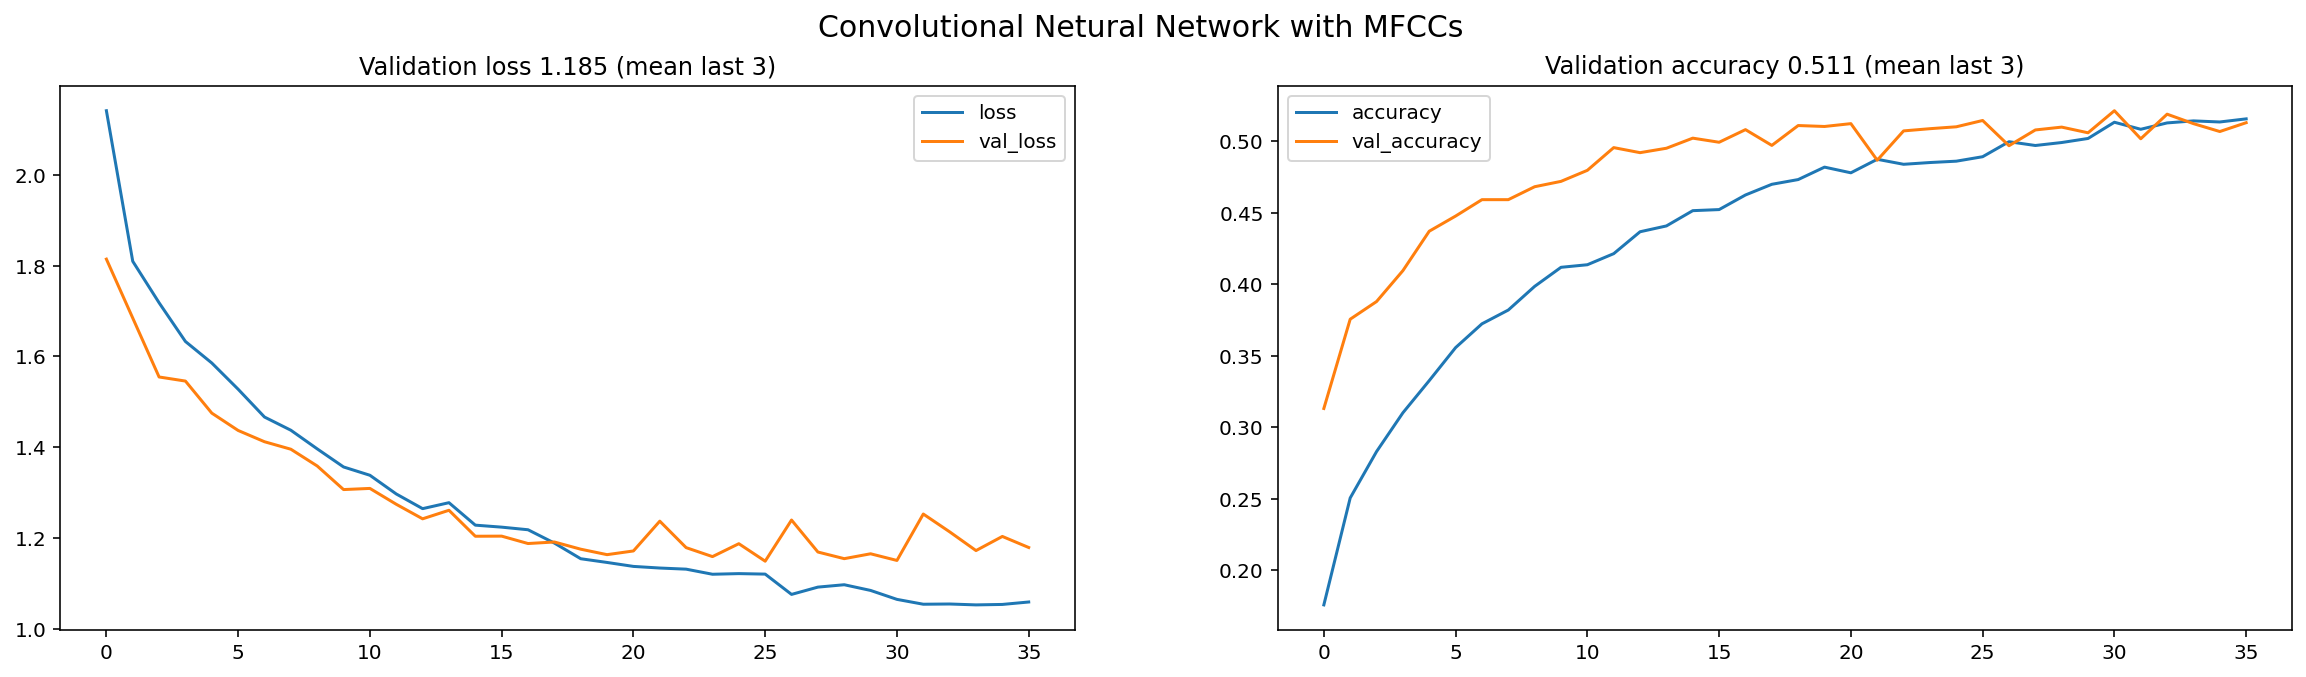

In [118]:
# Plots neural network performance metrics for train and validation
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
plt.suptitle('Convolutional Netural Network with MFCCs', size=15)
results = pd.DataFrame(history.history)
results[["loss", "val_loss"]].plot(ax=axs[0])
axs[0].set_title("Validation loss {:.3f} (mean last 3)".format(np.mean(history.history["val_loss"][-3:])))
results[["accuracy", "val_accuracy"]].plot(ax=axs[1])
axs[1].set_title("Validation accuracy {:.3f} (mean last 3)".format(np.mean(history.history["val_accuracy"][-3:])))
plt.savefig("/content/drive/MyDrive/LY Project/cnn_two_layers_training_curves.png")
plt.show()

In [119]:
# Collect loss and accuracy for the test set
loss_te, accuracy_te = model.evaluate(x_te, y_te)

print("Test loss: {:.2f}".format(loss_te))
print("Test accuracy: {:.2f}%".format(100 * accuracy_te))

53/53 [==============================] - 0s 7ms/step - loss: 1.1334 - accuracy: 0.5116
Test loss: 1.13
Test accuracy: 51.16%


53/53 [==============================] - 0s 4ms/step


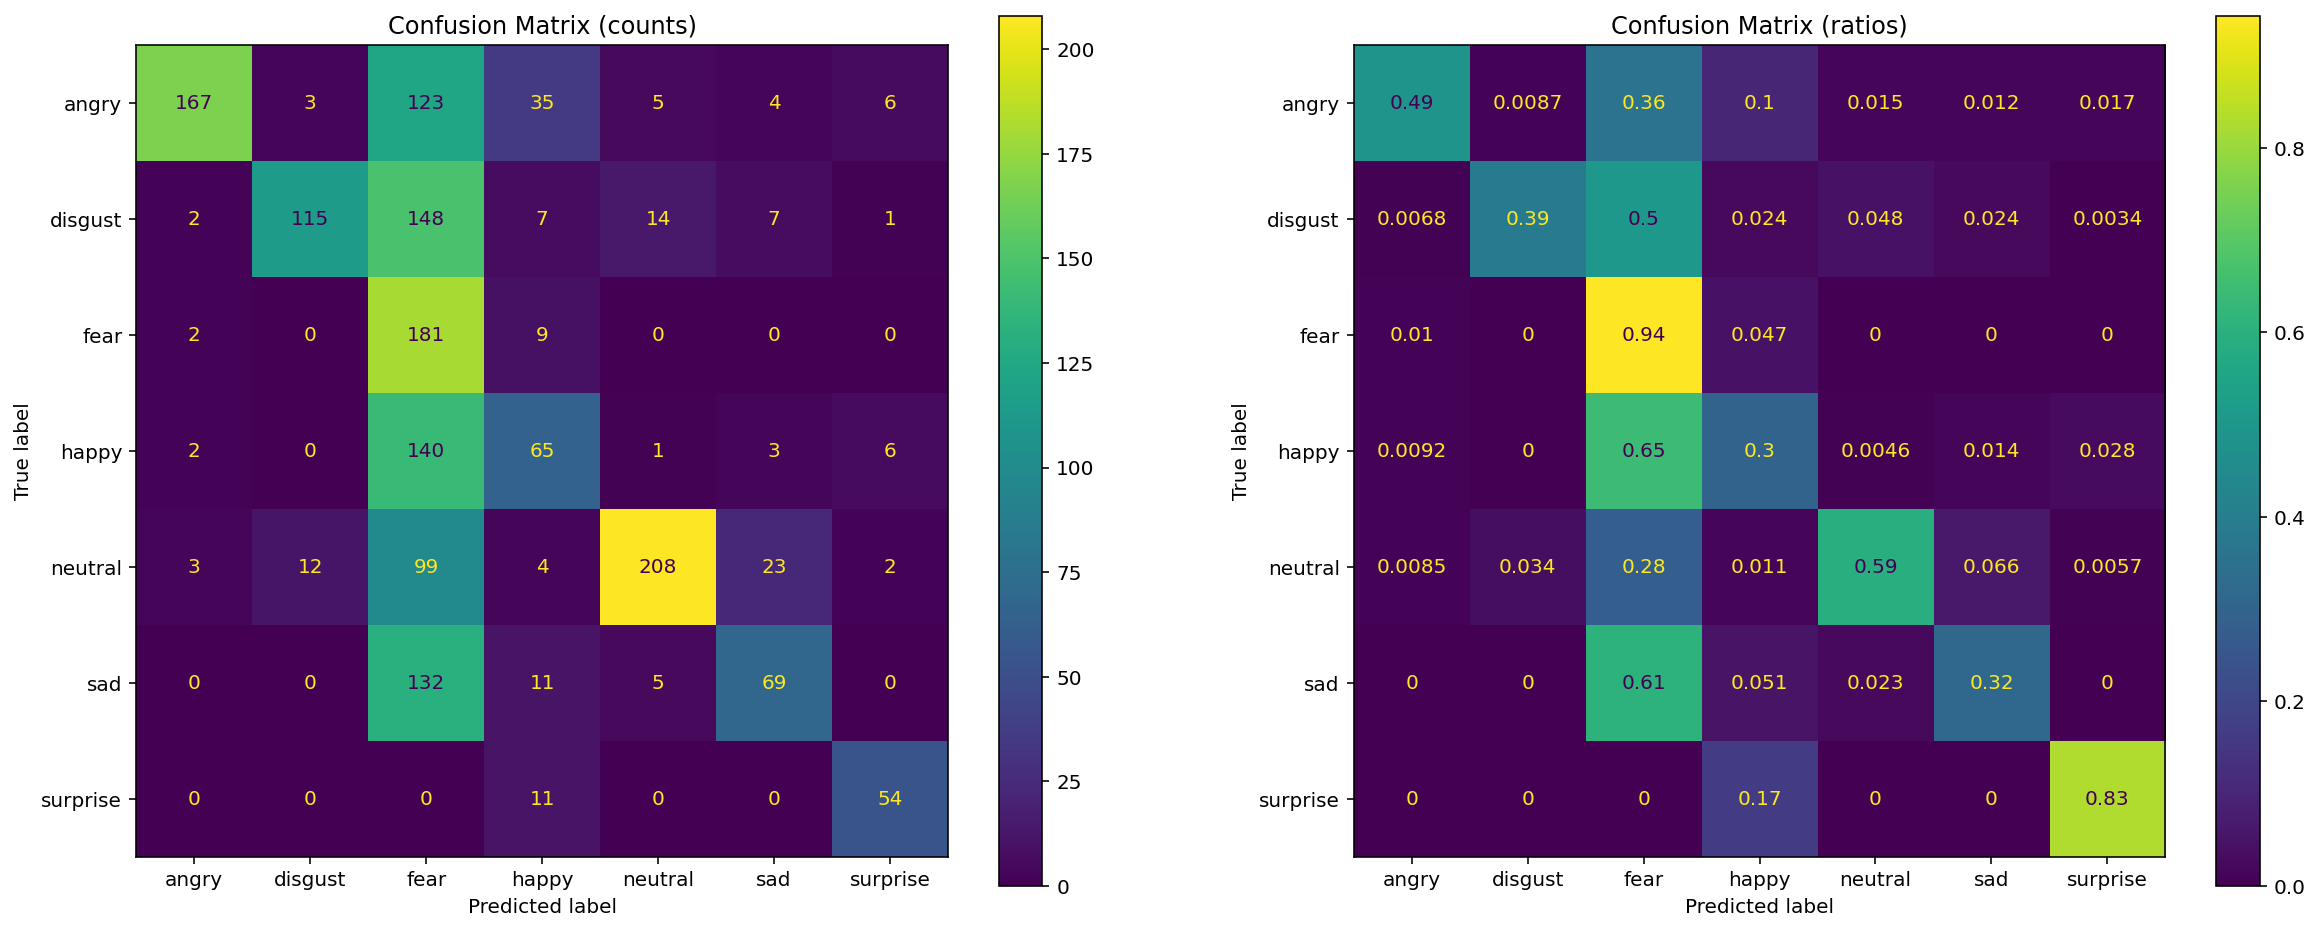

In [120]:
# Compute test set predictions
predictions = model.predict(x_te)

pred = []

for i in predictions:
    pred.append(np.argmax(i))
    
from sklearn.metrics import ConfusionMatrixDisplay

labels = {'angry':0,'disgust':1,'fear':2,'happy':3,'neutral':4,'sad':5,'surprise':6}

def plot_confusion_matrices(y_true, y_pred):

    # Create two subplots
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plots the standard confusion matrix
    ax1.set_title("Confusion Matrix (counts)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, ax=ax1)

    # Plots the normalized confusion matrix
    ax2.set_title("Confusion Matrix (ratios)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, normalize="true", ax=ax2)
    plt.savefig("/content/drive/MyDrive/LY Project/cnn_two_layers_confusion_matrices.png")
    plt.show()

# Plot confusion matrices
plot_confusion_matrices(y_te, pred)